In [1]:
import pandas as pd
import numpy as np

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, InputLayer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Normalization, CategoryEncoding
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, concatenate
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:

df = pd.read_csv('database/subset.txt', sep=';')
df_balanced = pd.read_csv('database/balancedDatasetT.txt', sep=';')
data = pd.concat([df, df_balanced], ignore_index=True)
#data = dd.read_parquet('2023_combined.parquet')

In [33]:
# Filter out irrelevant categories and handle missing data
#irrelevant_categories = ['020: Street Lighting: HOEP', '018: Unmetered Scattered Load', '021: Street Lighting: Tiered']
#data = data[~data['RATECLASS_DESC'].isin(irrelevant_categories)]
data['# of Chargers'] = pd.to_numeric(data['# of Chargers'], errors='coerce')

In [34]:
# Split data into labeled and unlabeled
labeled_data = data.dropna(subset=['# of Chargers'])
unlabeled_data = data[data['# of Chargers'].isna()].drop(columns=['# of Chargers'])

In [35]:
data

,YYYYMMDD,Location,RATECLASS_DESC,# of Chargers,R1,R2,R3,R4,R5,R6,...,R18,R19,R20,R21,R22,R23,R24,transformer_Location,Tx,ID
0,20230101,200,056: Residential: Tiered TOU Opt out,NaN,1.81,1.51,1.77,1.57,1.10,1.22,...,1.81,2.60,3.36,2.67,2.04,2.09,1.66,200.0,A122,136.0
1,20230102,200,056: Residential: Tiered TOU Opt out,NaN,1.87,1.66,1.31,1.15,1.00,0.89,...,1.51,1.62,2.32,5.80,1.63,1.34,0.88,200.0,A122,136.0
2,20230131,200,056: Residential: Tiered TOU Opt out,NaN,1.13,1.18,1.16,1.20,1.05,0.92,...,2.06,2.36,1.79,1.95,1.57,1.36,1.17,200.0,A122,136.0
3,20230103,200,056: Residential: Tiered TOU Opt out,NaN,0.83,0.99,0.96,0.86,0.85,0.80,...,1.78,2.03,2.10,1.98,1.76,1.39,0.92,200.0,A122,136.0
4,20230104,200,056: Residential: Tiered TOU Opt out,NaN,0.92,0.96,0.97,1.00,1.04,0.96,...,2.67,2.32,1.92,1.99,1.96,1.68,1.25,200.0,A122,136.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663620,20231227,4967,001: Residential: TOU,0.0,1.58,0.69,0.72,1.49,0.81,1.93,...,1.87,0.82,1.75,0.81,0.86,1.54,0.74,4967.0,B35,4021.0
663621,20231228,4967,001: Residential: TOU,0.0,1.46,0.88,0.64,1.59,0.72,1.96,...,1.80,0.73,1.91,1.65,2.01,0.69,1.59,4967.0,B35,4021.0
663622,20231229,4967,001: Residential: TOU,1.0,0.71,1.51,0.74,0.67,1.69,1.06,...,0.87,1.90,3.18,2.08,1.25,1.57,0.88,4967.0,B35,4021.0
663623,20231230,4967,001: Residential: TOU,1.0,0.71,1.61,0.79,1.39,1.33,1.66,...,1.17,1.52,6.17,8.82,9.93,4.72,1.69,4967.0,B35,4021.0


C:\Users\KelvinYe\AppData\Local\Temp\ipykernel_59796\4021946670.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=chargers_count.index, y=chargers_count.values, palette='viridis')


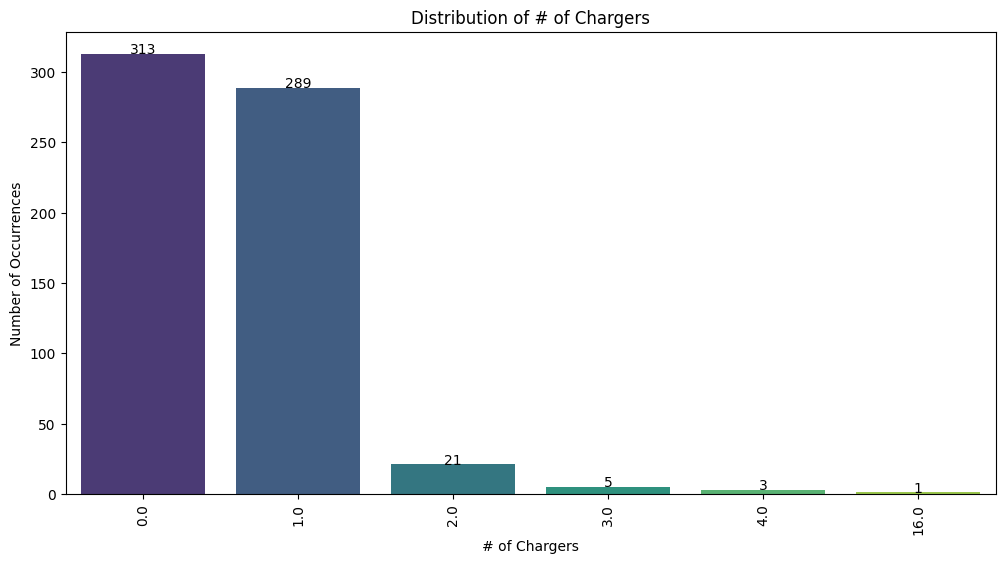

In [38]:
# Count the number of occurrences of each value in '# of Chargers'
chargers_count = filtered_data['# of Chargers'].value_counts().sort_index()

# Plot the labeled data
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=chargers_count.index, y=chargers_count.values, palette='viridis')
plt.xlabel('# of Chargers')
plt.ylabel('Number of Occurrences')
plt.title(f'Distribution of # of Chargers')
plt.xticks(rotation=90)

# Add values on top of the bars
for index, value in enumerate(chargers_count.values):
    barplot.text(index, value, f'{value}', color='black', ha="center")

plt.show()

In [39]:
# Prepare features
categorical_features = ['Location', 'RATECLASS_DESC']
numerical_features = [f'R{i}' for i in range(1, 25)]

# Convert categorical data to numerical codes
for feature in categorical_features:
    labeled_data[feature] = labeled_data[feature].astype('category').cat.codes
    unlabeled_data[feature] = unlabeled_data[feature].astype('category').cat.codes

C:\Users\KelvinYe\AppData\Local\Temp\ipykernel_59796\3414312708.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data[feature] = labeled_data[feature].astype('category').cat.codes
C:\Users\KelvinYe\AppData\Local\Temp\ipykernel_59796\3414312708.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data[feature] = labeled_data[feature].astype('category').cat.codes


In [40]:
# Split labeled data into training and validation
X_labeled = labeled_data[numerical_features + categorical_features]
y_labeled = labeled_data['# of Chargers']
X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)


In [41]:
# Prepare unlabeled data
X_unlabeled = unlabeled_data[numerical_features + categorical_features]

In [46]:
# Define and train the initial model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='linear')  # Output layer
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10


E:\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5810/5810 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 168.2578 - val_loss: 2.2043
Epoch 2/10
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 2.2307 - val_loss: 1.3843
Epoch 3/10
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 1.4745 - val_loss: 0.9185
Epoch 4/10
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 1.0124 - val_loss: 0.8605
Epoch 5/10
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.9486 - val_loss: 0.7546
Epoch 6/10
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.9290 - val_loss: 0.8136
Epoch 7/10
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.9336 - val_loss: 0.7960
Epoch 8/10
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.9391 - val_loss: 0.7364
Epoch 9/10
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.9062 - val_loss: 0.8938
Epoch 10/10
5810/5810 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.8869 - val_loss: 0.8085


In [51]:
# Predict on the test set
# Evaluate the model on the validation set
val_predictions = model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
val_r2 = r2_score(y_val, val_predictions)
print(f'Validation Mean Squared Error: {val_mse}')
print(f'Validation R^2 Score: {val_r2}')

1453/1453 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Validation Mean Squared Error: 0.7685680437484789
Validation R^2 Score: 0.2619654723096836


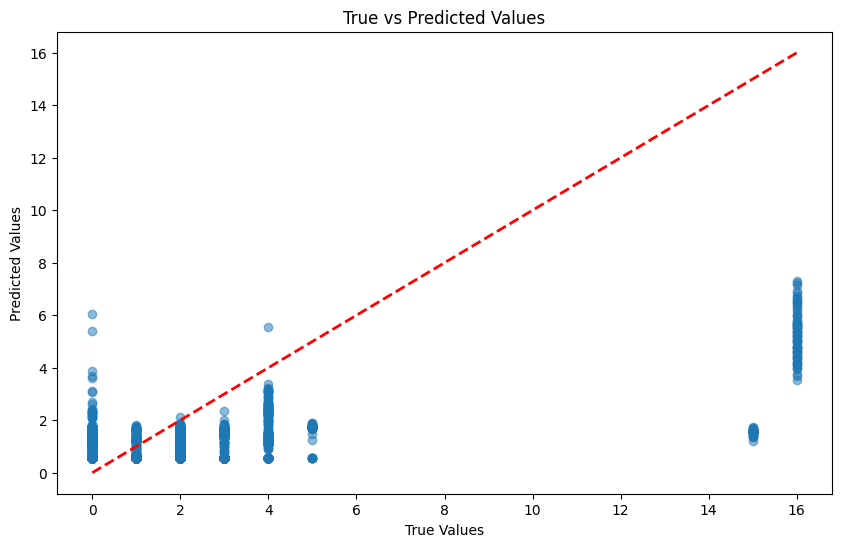

In [45]:
# Visualize true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, val_predictions, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

# next

In [16]:
# Predict on unlabeled data
unlabeled_predictions = model.predict(X_unlabeled)
pseudo_labels = unlabeled_predictions.flatten()  # Convert to 1D array if needed

# Create a new dataset with pseudo-labels where confidence is high
threshold = 0.5  # Define your own threshold based on your confidence
high_confidence_indices = np.where(pseudo_labels > threshold)[0]
X_high_confidence = X_unlabeled.iloc[high_confidence_indices]
y_high_confidence = pseudo_labels[high_confidence_indices]

# Combine pseudo-labeled data with original labeled data
X_combined = pd.concat([X_train, X_high_confidence])
y_combined = np.concatenate([y_train, y_high_confidence])

# Retrain the model
model.fit(X_combined, y_combined, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
final_predictions = model.predict(X_val)
final_mse = mean_squared_error(y_val, final_predictions)
print(f'Final Mean Squared Error: {final_mse}')

13476/13476 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
Epoch 1/20


ValueError: Cannot take the length of shape with unknown rank.

new

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from scipy.sparse import issparse, vstack

In [10]:
# Load and preprocess data
df = pd.read_csv('database/subset.txt', sep=';')
df_balanced = pd.read_csv('database/balancedDatasetT.txt', sep=';')
data = pd.concat([df, df_balanced], ignore_index=True)
data['# of Chargers'] = pd.to_numeric(data['# of Chargers'], errors='coerce')

labeled_data = data.dropna(subset=['# of Chargers'])
unlabeled_data = data[data['# of Chargers'].isna()].drop(columns=['# of Chargers'])

categorical_features = ['Location', 'RATECLASS_DESC']
numerical_features = [f'R{i}' for i in range(1, 25)]

In [21]:
# Create preprocessing pipelines
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Prepare the data
X_labeled = labeled_data[numerical_features + categorical_features]
y_labeled = labeled_data['# of Chargers'].values

X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)


In [22]:
# Fit the preprocessor on the training data and transform both training and validation data
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)

# Transform unlabeled data
X_unlabeled_preprocessed = preprocessor.transform(unlabeled_data[numerical_features + categorical_features])

# Scale the target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()


In [26]:
# Define model creation function
def create_model(input_shape):
    model = Sequential([
        InputLayer(input_shape=input_shape),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1)  # No activation for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [29]:
# Iterative Self-Training
n_iterations = 5
pseudo_label_ratio = 0.1  # Start with 10% of unlabeled data

X_pseudo = None
y_pseudo = np.array([])

for iteration in range(n_iterations):
    print(f"Iteration {iteration + 1}/{n_iterations}")
    
    # Create and train model
    model = create_model((X_train_preprocessed.shape[1],))
    model.fit(X_train_preprocessed, y_train_scaled, epochs=20, batch_size=32, 
              validation_data=(X_val_preprocessed, y_val_scaled), verbose=0)
    
    # Evaluate
    val_predictions_scaled = model.predict(X_val_preprocessed).flatten()
    val_predictions = scaler_y.inverse_transform(val_predictions_scaled.reshape(-1, 1)).flatten()
    val_mse = mean_squared_error(y_val, val_predictions)
    val_r2 = r2_score(y_val, val_predictions)
    print(f'Validation MSE: {val_mse:.4f}, R^2: {val_r2:.4f}')
    
    # Predict on remaining unlabeled data
    unlabeled_predictions_scaled = model.predict(X_unlabeled_preprocessed).flatten()
    
    # Select high-confidence predictions
    n_pseudo = int(len(unlabeled_predictions_scaled) * pseudo_label_ratio)
    sorted_indices = np.argsort(np.abs(unlabeled_predictions_scaled))[::-1]
    high_confidence_indices = sorted_indices[:n_pseudo]
    
    # Add new pseudo-labeled data
    X_pseudo_new = X_unlabeled_preprocessed[high_confidence_indices]
    y_pseudo_new = unlabeled_predictions_scaled[high_confidence_indices]
    
    # Update pseudo-labeled data
    if X_pseudo is None:
        X_pseudo = X_pseudo_new
    else:
        X_pseudo = vstack([X_pseudo, X_pseudo_new]) if issparse(X_pseudo) else np.vstack([X_pseudo, X_pseudo_new])
    y_pseudo = np.concatenate([y_pseudo, y_pseudo_new])
    
    # Update training data
    X_train_preprocessed = vstack([X_train_preprocessed, X_pseudo]) if issparse(X_train_preprocessed) else np.vstack([X_train_preprocessed, X_pseudo])
    y_train_scaled = np.concatenate([y_train_scaled, y_pseudo])
    
    # Remove pseudo-labeled data from unlabeled pool
    mask = np.ones(X_unlabeled_preprocessed.shape[0], dtype=bool)
    mask[high_confidence_indices] = False
    X_unlabeled_preprocessed = X_unlabeled_preprocessed[mask]
    
    # Increase pseudo-label ratio for next iteration
    pseudo_label_ratio = min(pseudo_label_ratio * 1.5, 1.0)

Iteration 1/5


E:\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1453/1453 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Validation MSE: 0.6169, R^2: 0.4076
13476/13476 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step
Iteration 2/5


E:\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1453/1453 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
Validation MSE: 0.5501, R^2: 0.4718
12129/12129 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step
Iteration 3/5


E:\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1453/1453 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Validation MSE: 0.5974, R^2: 0.4264
10310/10310 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step
Iteration 4/5


E:\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1453/1453 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Validation MSE: 0.7082, R^2: 0.3200
7990/7990 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step
Iteration 5/5


E:\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


KeyboardInterrupt: 

In [30]:
# Final evaluation
final_model = create_model((X_train_preprocessed.shape[1],))
final_model.fit(X_train_preprocessed, y_train_scaled, epochs=20, batch_size=32, 
                validation_data=(X_val_preprocessed, y_val_scaled), verbose=0)

final_predictions_scaled = final_model.predict(X_val_preprocessed).flatten()
final_predictions = scaler_y.inverse_transform(final_predictions_scaled.reshape(-1, 1)).flatten()
final_mse = mean_squared_error(y_val, final_predictions)
final_r2 = r2_score(y_val, final_predictions)
print(f'Final Validation MSE: {final_mse:.4f}, R^2: {final_r2:.4f}')

# Visualize results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, final_predictions, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values (After Iterative Self-Training)')
plt.show()

KeyboardInterrupt: 